**Importações e Leitura da Imagem**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Leitura da imagem original (cinza e colorida)
imagem_entrada = cv2.imread('imgs\\Q2\\XRay.png', cv2.IMREAD_GRAYSCALE)
img_original_cor = cv2.imread('imgs\\Q2\\XRay.png')

**Detecção da Mão**

In [ ]:
# Filtro passa-alta personalizado para destacar a mão
filtro_mao = np.array([[ 1, 1, 1], [1, -4, 1], [1, 1, 1]], dtype=np.float32)

imagem_mao = cv2.GaussianBlur(imagem_entrada, (7, 7), 0) # Suavização da imagem
img_mao_filtrada = cv2.filter2D(imagem_mao, -1, filtro_mao) # Aplicação do filtro

_, final_mao = cv2.threshold(img_mao_filtrada, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) #Binarização automática

kernel_mao = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)) # Máscara para refinamento
# Operações morfológicas
final_mao = cv2.morphologyEx(final_mao, cv2.MORPH_OPEN, kernel_mao, iterations=5)
final_mao = cv2.morphologyEx(final_mao, cv2.MORPH_CLOSE, kernel_mao, iterations=2)

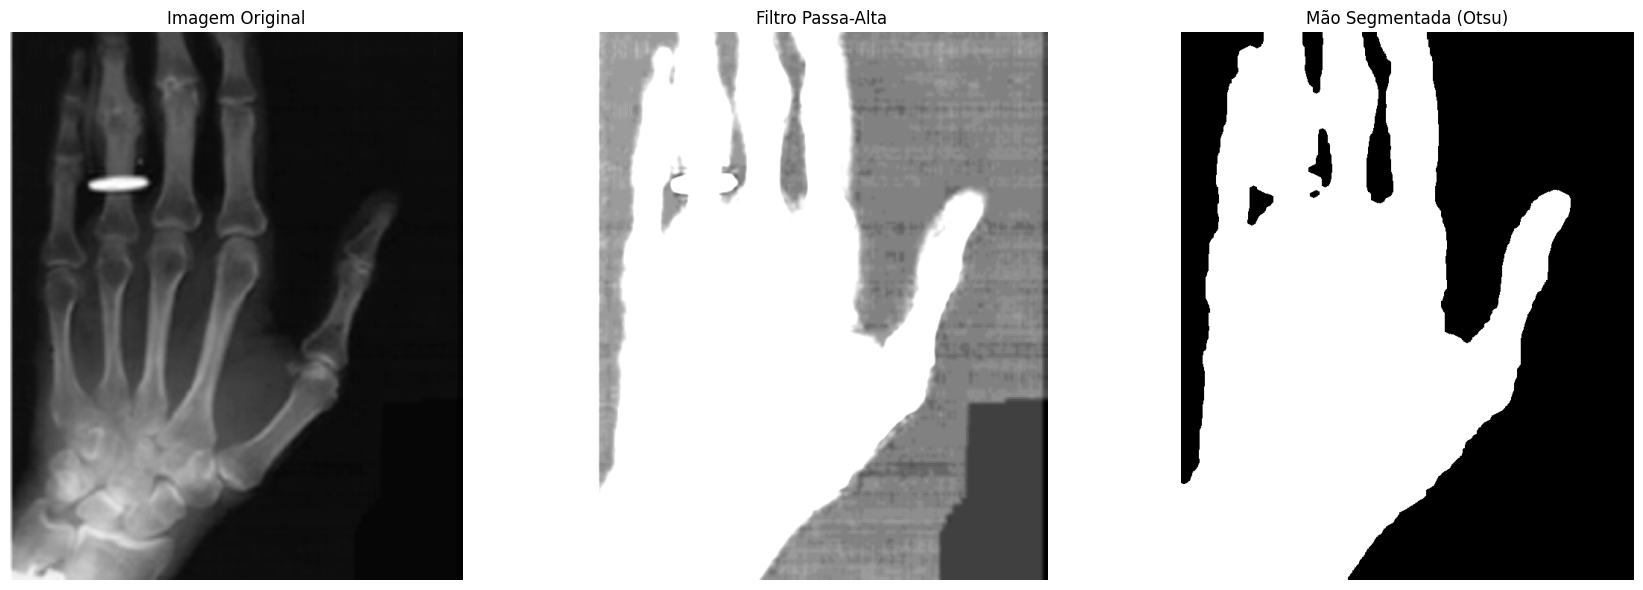

In [3]:
# Exibição
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(imagem_mao, cmap='gray')
plt.title("Imagem Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_mao_filtrada, cmap='gray')
plt.title("Filtro Passa-Alta")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(final_mao, cmap='gray')
plt.title("Mão Segmentada (Otsu)")
plt.axis('off')
plt.tight_layout()
plt.show()

**Detecção dos Ossos**

In [4]:
def filtro_passa_alta_gaussiano(imagem, sigma=1):
    f = np.fft.fft2(imagem) # Aplica a Transformada de Fourier bidimensional para obter a imagem no domínio da frequência
    fshift = np.fft.fftshift(f) # Centraliza o espectro de frequência
    linhas, colunas = imagem.shape

    # Cria eixos espaciais centrados para construção do filtro gaussiano
    x = np.linspace(-colunas // 2, colunas // 2, colunas)
    y = np.linspace(-linhas // 2, linhas // 2, linhas)
    X, Y = np.meshgrid(x, y)
    D = np.sqrt(X**2 + Y**2) # Calcula a distância de cada ponto ao centro (distância radial)
    gauss_alta = 1 - np.exp(-(D**2) / (2 * sigma**2)) # Define o filtro passa-alta gaussiano: 1 - gaussiana de baixa frequência
    f_filtrado = fshift * gauss_alta # Aplica o filtro multiplicando no domínio da frequência
    imagem_resultado = np.abs(np.fft.ifft2(np.fft.ifftshift(f_filtrado))) # Converte o espectro filtrado de volta para o domínio espacial
    return np.uint8(np.clip(imagem_resultado, 0, 255))

# Correção gama
def aplicar_gamma(imagem, gamma=1.0):
    tabela = np.array([(i / 255.0) ** (1/gamma) * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(imagem, tabela)

In [ ]:
# Aplicar filtro passa-alta
imagem_filtrada = filtro_passa_alta_gaussiano(imagem_entrada, sigma=1)

imagem_gamma = aplicar_gamma(imagem_filtrada, 1.4) # Aplica a correção gamma

# Cria uma máscara circular invertida para fechamento
mascara_circular = np.zeros((30, 10), dtype=np.uint8)
cv2.circle(mascara_circular, (5, 15), 4, 255, -1)
mascara_circular = cv2.bitwise_not(mascara_circular)

kernel_ossos = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)) #Máscara para refinamento

# Binarização com Otsu após a correção gamma
_, otsu = cv2.threshold(imagem_gamma, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
otsu = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, mascara_circular, iterations=2)
otsu = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel_ossos, iterations=1)
otsu = cv2.dilate(otsu, kernel_ossos, iterations=1)

# Filtro de bordas com Sobel
sobel_x = cv2.Sobel(imagem_filtrada, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(imagem_filtrada, cv2.CV_64F, 0, 1, ksize=5)
magnitude = np.uint8(np.clip(cv2.magnitude(sobel_x, sobel_y), 0, 255))

# Otsu na magnitude + morfologia
_, sobel_bin = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
sobel_bin = cv2.erode(sobel_bin, kernel_ossos, iterations=3)
sobel_bin = cv2.morphologyEx(sobel_bin, cv2.MORPH_CLOSE, kernel_ossos, iterations=3)
sobel_bin = cv2.dilate(sobel_bin, kernel_ossos, iterations=2)

# Fusão: união entre binarização por gama e sobel
final_ossos = np.where((otsu == 255) | (sobel_bin == 255), 255, 0).astype("uint8")
final_ossos = cv2.morphologyEx(final_ossos, cv2.MORPH_CLOSE, kernel_ossos, iterations=2)

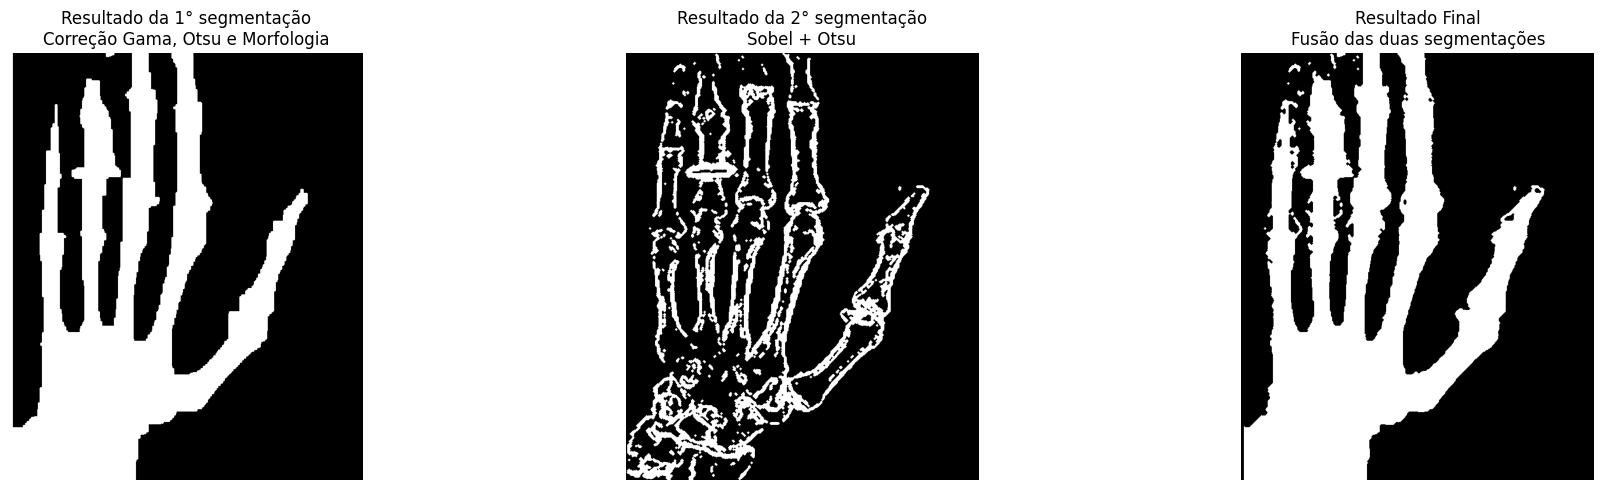

In [13]:
# Exibição
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.imshow(otsu, cmap='gray')
plt.title("Resultado da 1° segmentação\nCorreção Gama, Otsu e Morfologia")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sobel_bin, cmap='gray')
plt.title("Resultado da 2° segmentação\nSobel + Otsu")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(final_ossos, cmap='gray')
plt.title("Resultado Final\nFusão das duas segmentações")
plt.axis('off')
plt.tight_layout()
plt.show()


**Detecção do Anel**

In [7]:
img_dedos = imagem_entrada[:-250, :]  # Recorta a imagem para focar na região dos dedos, área de interesse para a identificação do anel
img_dedos = np.pad(img_dedos, ((0, 250), (0, 0)), mode='constant', constant_values=0)  # Preenche a parte faltante com zeros (padding)

# A presença de um anel metálico no raio-X é identificada pela sua alta intensidade (brilho) devido à forte absorção de raios-X.
# Para destacar esse anel, utilizamos um limiar baseado no percentil 90 da imagem. O percentil 90 é escolhido automaticamente
# para garantir que estamos considerando os 10% mais brilhantes da imagem, ou seja, as regiões com maior intensidade 
# (que são geralmente as áreas de maior absorção de raios-X, como o anel metálico). 
limiar = np.percentile(imagem_entrada, 90)  # Calcula o limiar baseado no percentil 90 da imagem
img_dedos[imagem_entrada <= limiar] = 0  # Zera os pixels abaixo do limiar, destacando as áreas brilhantes

# Aplica o método de Otsu para binarizar a imagem e realçar as áreas de interesse
_, imagem_binarizada = cv2.threshold(img_dedos, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Cria um kernel elíptico para realizar a correspondência do anel metálico
kernel_anel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (51, 11))

# Realiza a erosão para eliminar ruídos pequenos e destacar a forma do anel
anel_detectado = cv2.erode(imagem_binarizada, kernel_anel, iterations=1)

# Realiza a dilatação para restaurar o formato do anel após a erosão
final_anel = cv2.dilate(anel_detectado, kernel_anel, iterations=1)


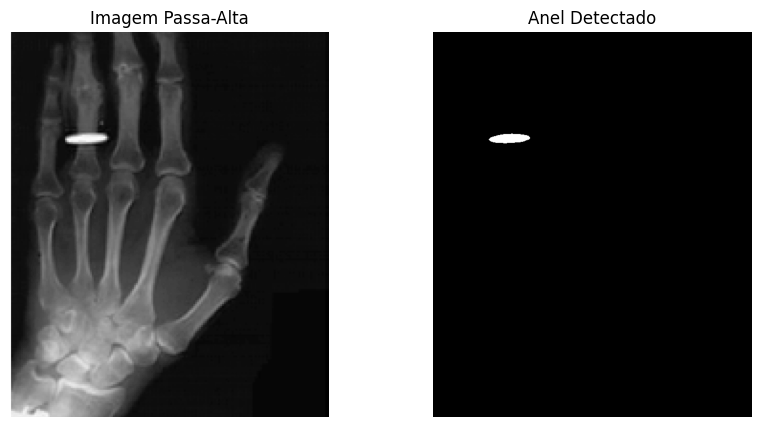

In [8]:
# Exibição
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(imagem_entrada, cmap='gray')
plt.title("Imagem Passa-Alta")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Anel Detectado")
plt.imshow(final_anel, cmap='gray')
plt.axis('off')
plt.show()

**Exibição dos Resultados**

In [9]:
# Destacar o anel em vermelho
img_mao = img_original_cor.copy()
final_mao[:,0:5] = 0
img_mao[final_mao == 255] = [255, 0, 0] #BGR

img_ossos = img_original_cor.copy()
final_ossos[:,0:5] = 0
img_ossos[final_ossos == 255] = [0, 0, 255] #BGR

img_anel = img_original_cor.copy()
img_anel[final_anel == 255] = [0, 0, 255] #BGR

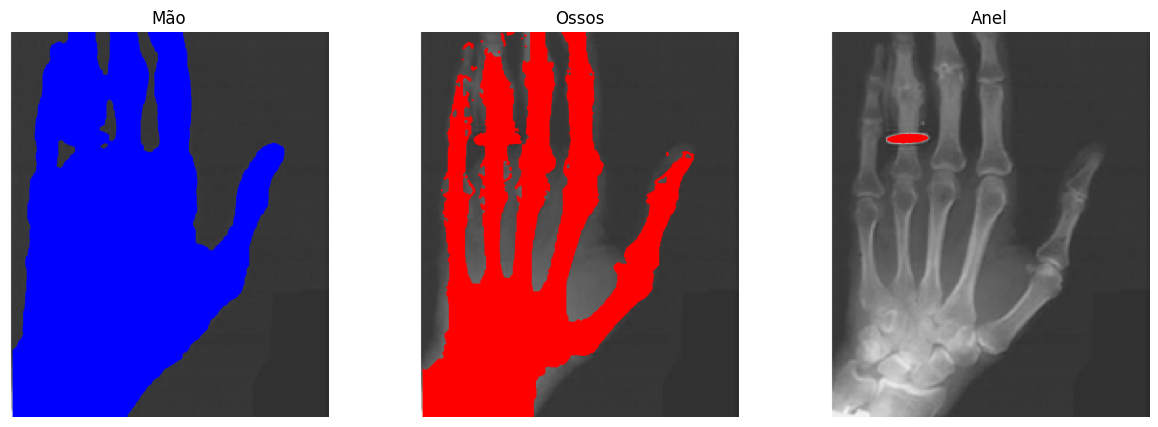

In [10]:
# Exibição
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img_mao, cv2.COLOR_BGR2RGB))
plt.title("Mão")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ossos")
plt.imshow(cv2.cvtColor(img_ossos, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Anel")
plt.imshow(cv2.cvtColor(img_anel, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()